<a href="https://colab.research.google.com/github/mkeohane01/GAN-Image-Denoising/blob/denoise-gan-dev/notebooks/GAN_WORKING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 7 - SuperResolution and GAN's

## Lesson Video:

In [1]:
#hide
#Run once per session
!pip install fastai wwf -q --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [2]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai` : 2.7.14 
* `fastcore` : 1.5.29 
* `wwf` : 0.0.16 
---

## What is a GAN?
The Generative Adversarial Network was invented by Ian Goodfellow, where two networks play a game. In our case, we will build a 'crappifier' to make images worse, and the critic will try to determine which is fake and which is the original. This will help us achieve super-resolution

In [3]:
from fastai.vision.all import *
from fastai.vision.gan import *

## Crappified data

Let's build a function first that will go through and 'crappify' some data:

In [4]:
from PIL import ImageDraw, ImageFont

In [5]:
def resize_to(img, targ_sz, use_min=False):
    w,h = img.size
    min_sz = (min if use_min else max)(w,h)
    ratio = targ_sz/min_sz
    return int(w*ratio),int(h*ratio)

In [6]:
class Crappifier():
  "Quickly draw tesxt and numbers on an image"
  def __init__(self, path_lr, path_hr):
      self.path_lr = path_lr
      self.path_hr = path_hr

  def __call__(self, fn):
      dest = self.path_lr/fn.relative_to(self.path_hr)
      dest.parent.mkdir(parents=True, exist_ok=True)
      img = Image.open(fn)
      targ_sz = resize_to(img, 96, use_min=True)
      img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
      w,h = img.size
      q = random.randint(10,70)
      ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
      img.save(dest, quality=q)

And now let's get some data to work with. We'll use the `PETS` dataset:

In [8]:
!pip install kaggle
from google.colab import files
files.upload()

# Download kaggle dataset
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Small dataset
!kaggle datasets download -d rajat95gupta/smartphone-image-denoising-dataset


Saving kaggle.json to kaggle.json
100% 6.16G/6.16G [03:24<00:00, 29.6MB/s]
100% 6.16G/6.16G [03:24<00:00, 32.3MB/s]


In [9]:
# Unzip the smartphone denoising dataset
!unzip '/content/smartphone-image-denoising-dataset.zip'

Archive:  /content/smartphone-image-denoising-dataset.zip
  inflating: SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00020_3200_N/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00020_3200_N/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0003_001_S6_00100_00060_3200_H/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0003_001_S6_00100_00060_3200_H/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0004_001_S6_00100_00060_4400_L/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0004_001_S6_00100_00060_4400_L/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0005_001_S6_00100_00060_4400_N/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0005_001_S6_00100_00060_4400_N/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0006_001

In [10]:
import os
import shutil

# Function to load image pairs from a folder
def load_image_pairs(folder):
    gt_folder = os.path.join(folder, 'gt')
    noisy_folder = os.path.join(folder, 'noisy')

    # Clear the contents of the gt_folder and noisy_folder if they exist
    if os.path.exists(gt_folder):
        shutil.rmtree(gt_folder)
    if os.path.exists(noisy_folder):
        shutil.rmtree(noisy_folder)

    if not os.path.exists(gt_folder):
        os.makedirs(gt_folder)
        print('created gt: ', gt_folder)
    if not os.path.exists(noisy_folder):
        os.makedirs(noisy_folder)
        print('created noisy: ', noisy_folder)

    for i, (root, dirs, files) in enumerate(os.walk(folder)):
        if root == gt_folder or root == noisy_folder:
            continue  # Skip the gt_folder and noisy_folder
        for file in files:
            if 'GT' in file:
                filename, ext = os.path.splitext(file)
                new_filename = f"{'_'.join(filename.split('_')[1:])}_{i}{ext}"
                shutil.move(os.path.join(root, file), os.path.join(gt_folder, new_filename))
            elif 'NOISY' in file:
                filename, ext = os.path.splitext(file)
                new_filename = f"{'_'.join(filename.split('_')[1:])}_{i}{ext}"
                shutil.move(os.path.join(root, file), os.path.join(noisy_folder, new_filename))

    gt_images = [os.path.join(gt_folder, file) for file in os.listdir(gt_folder)]
    noisy_images = [os.path.join(noisy_folder, file) for file in os.listdir(noisy_folder)]

    print("Number of images in 'gt' folder:", len(gt_images))
    print("Number of images in 'noisy' folder:", len(noisy_images))

    #return [], []
    return gt_images, noisy_images

# Load image pairs from the folder
gt_images, noisy_images = load_image_pairs('/content/SIDD_Small_sRGB_Only/Data')

created gt:  /content/SIDD_Small_sRGB_Only/Data/gt
created noisy:  /content/SIDD_Small_sRGB_Only/Data/noisy
Number of images in 'gt' folder: 160
Number of images in 'noisy' folder: 160


We'll make two folders, one for the low resolution (LR) and high resolution (HR) photos:

In [11]:
path = Path('/content/SIDD_Small_sRGB_Only/Data')
path_hr = path/'gt'
path_lr = path/'noisy'

In [12]:
path_hr

Path('/content/SIDD_Small_sRGB_Only/Data/gt')

Now let's generate our dataset!

In [13]:
items = get_image_files(path_hr)

Let's take a look at one of our generated images:

In [14]:
bad_im = get_image_files(path_lr)

In [15]:
im1 = PILImage.create(items[0])
im2 = PILImage.create(bad_im[0])

original
bad


<Axes: >

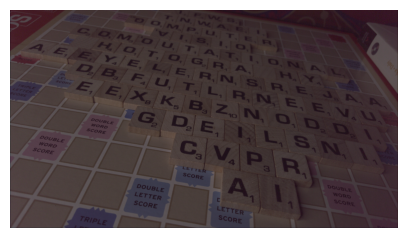

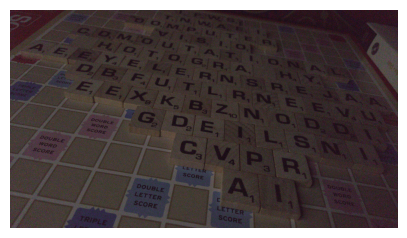

In [16]:
print('original')
im1.show();
print('bad')
im2.show(figsize=(5,5))

Great! We have some data now! Let's build the `DataBlock`

## DataBlock

In [17]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])

But for today's lesson, we'll go back to that progressive resizing technique we talked about. We want a function that can accept a `batch_size` and a `im_size`. Let's build that:

In [18]:
path_hr

Path('/content/SIDD_Small_sRGB_Only/Data/gt')

In [19]:
def get_dls(bs:int, size:int):
  "Generates two `GAN` DataLoaders"
  dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path_lr, bs=bs, path=path)
  dls.c = 3 # For 3 channel image
  return dls

## Pre-Trained Generator

The goal of this model will be to generate our "Super Resolution" images (or to make an image look better)

In [20]:
dls_gen = get_dls(32, 128)

On the left will be our 'crappified' image, and the right our original

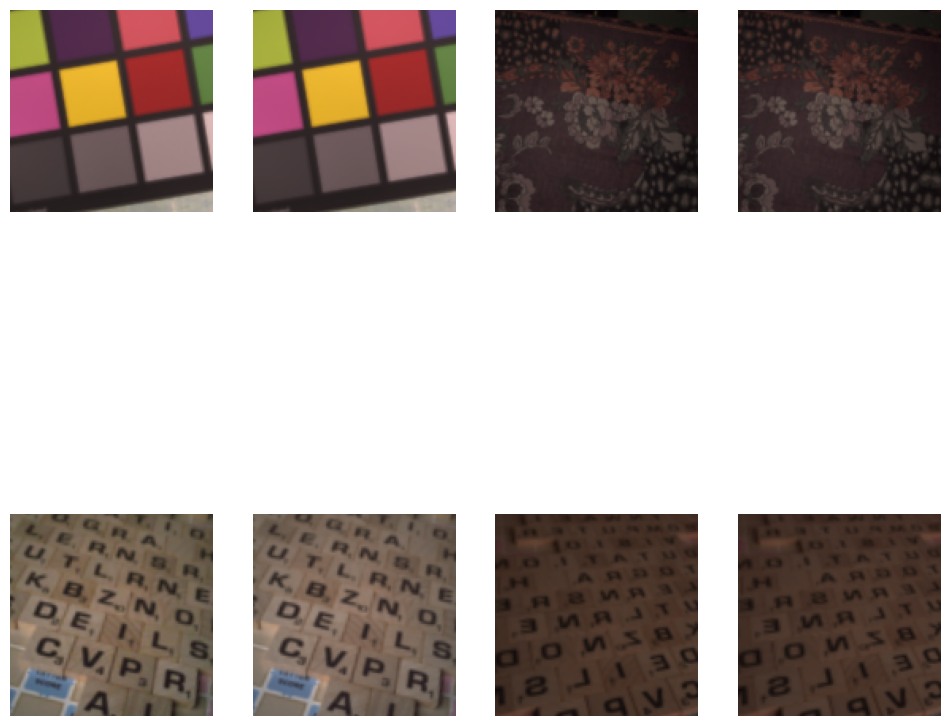

In [21]:
dls_gen.show_batch(max_n=4, figsize=(12,12))

Now let's build some models (with recommended hyper-parameters)

In [22]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

For our backbone, we'll use a resnet34

In [23]:
from fastai.vision.learner import unet_learner
from fastai.vision.all import *
from fastai.vision.models.unet import *

In [24]:
bbone = resnet34
#cfg = unet_config(blur=True, norm_type=NormType.Weight, self_attention=True,
#                  y_range=y_range)

In [65]:
def create_gen_learner():
  return unet_learner(dls_gen, bbone, loss_func=loss_gen, blur=True, norm_type=NormType.Weight, self_attention=True, y_range=y_range)

In [66]:
learn_gen = create_gen_learner()

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Let's fit our model quickly (we don't need to train for very long)

In [67]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,1.444323,0.969388,01:03
1,0.942345,0.164296,01:04


Let's unfreeze and fit a bit more!

In [68]:
learn_gen.unfreeze()

In [69]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.340330,0.328684,01:04
1,0.258274,0.119444,01:04
2,0.208194,0.071443,01:05


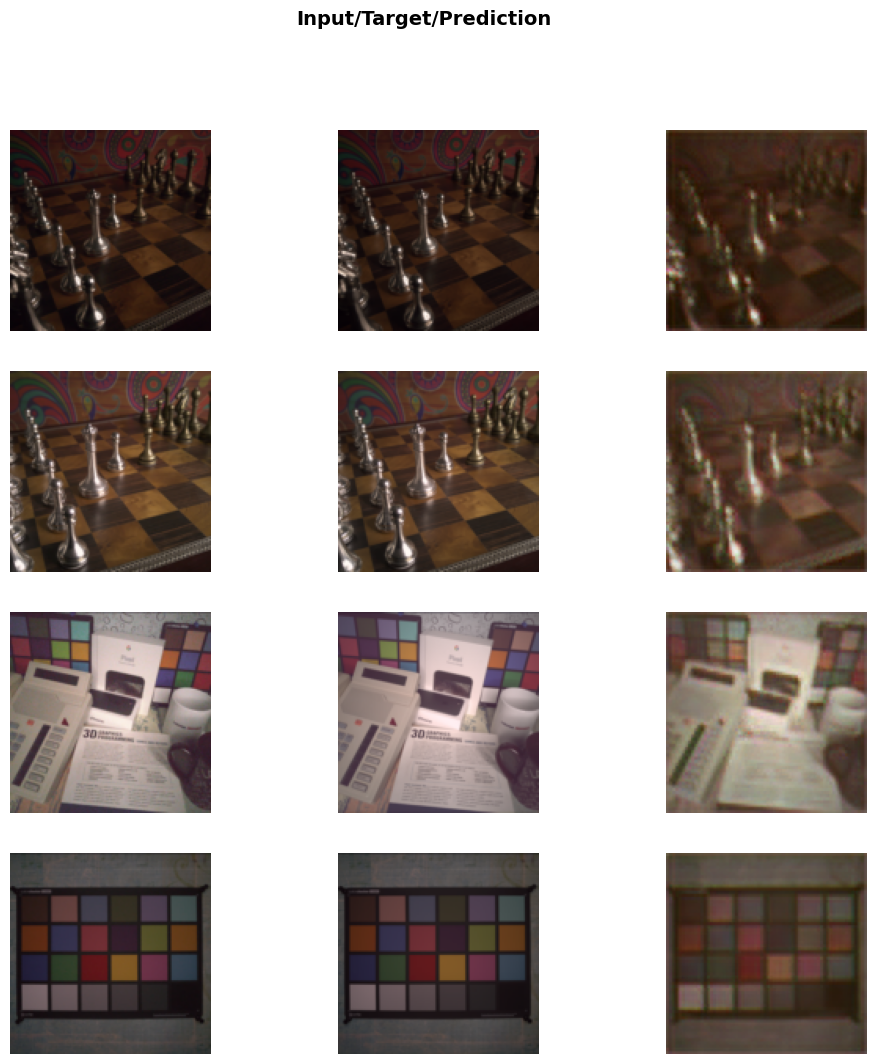

In [70]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [31]:
learn_gen.save('gen-pre2')

Path('/content/SIDD_Small_sRGB_Only/Data/models/gen-pre2.pth')

## Save the generated images

Now we need these generated images saved away so we can use them for our `critic` model. Let's do so:

In [32]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [33]:
path_gen.mkdir(exist_ok=True)

In [34]:
def save_preds(dl, learn):
  "Save away predictions"
  names = dl.dataset.items

  preds,_ = learn.get_preds(dl=dl)
  for i,pred in enumerate(preds):
      dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
      arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
      Image.fromarray(arr).save(path_gen/names[i].name)

We'll want to get rid of any augmentation, `drop_last`, and `shuffle` from our training `DataLoader`:

In [35]:
dl = dls_gen.train.new(shuffle=False, drop_last=False,
                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

Now let's look at what we're actually doing

In [36]:
preds, _ = learn_gen.get_preds(dl=dl)

In [37]:
preds[0].shape

torch.Size([3, 128, 128])

In [38]:
preds[0][None].shape

torch.Size([1, 3, 128, 128])

In [39]:
dec = dl.after_batch.decode((TensorImage(preds[0][None]),))[0][0]

In [40]:
arr = dec.numpy().transpose(1,2,0)

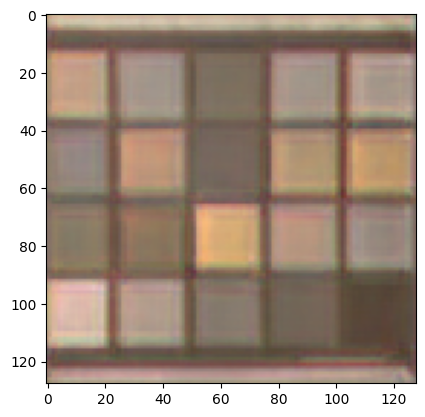

In [41]:
plt.imshow(arr.astype(np.uint8))

Now let's go save it away.

In [42]:
save_preds(dl, learn_gen)

## Training the critic

Now let's build our critic model

In [43]:
path_gen

Path('/content/SIDD_Small_sRGB_Only/Data/image_gen')

In [44]:
name_gen

'image_gen'

In [45]:
# We have to do this because of a bug for right now
path_g = get_image_files(path/name_gen)
path_i = get_image_files(path/'gt')
fnames = path_g + path_i

In [46]:
fnames[0]

Path('/content/SIDD_Small_sRGB_Only/Data/image_gen/SRGB_010_39.PNG')

In [47]:
def get_crit_dls(fnames, bs:int, size:int):
  "Generate two `Critic` DataLoaders"
  splits = RandomSplitter(0.1)(fnames)
  dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]],
                 splits=splits)
  tfms = [ToTensor(), Resize(size)]
  gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
  return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms)

In [48]:
dls_crit = get_crit_dls(fnames, bs=32, size=128)

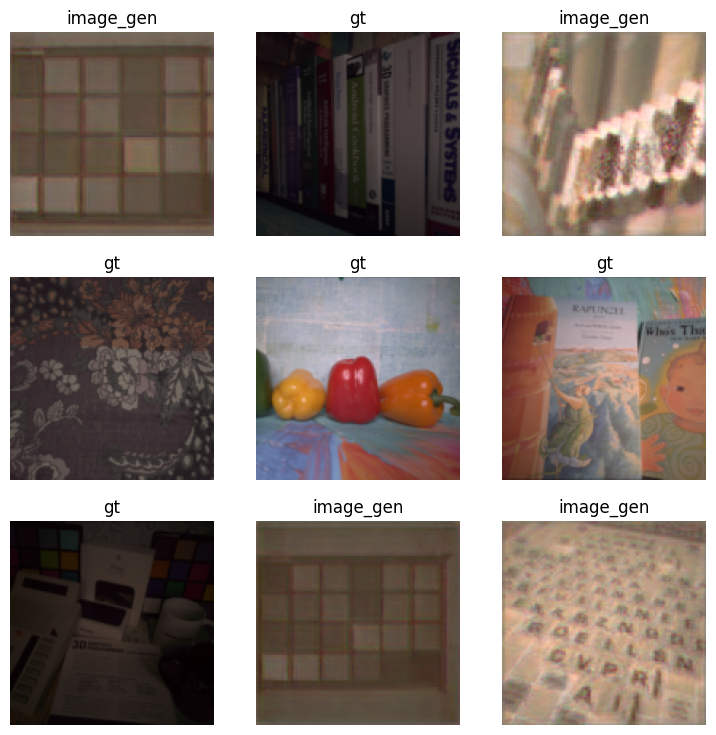

In [49]:
dls_crit.show_batch()

In [50]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [51]:
def create_crit_learner(dls, metrics):
  return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [52]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

And now let's fit!

In [53]:
learn_crit.fit_one_cycle(6, 1e-3, wd=wd)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.641932,0.947372,0.464286,00:27
1,0.584107,0.407233,0.810000,00:27
2,0.433212,0.127869,0.944286,00:27
3,0.331696,0.135253,0.944286,00:27
4,0.256557,0.023695,0.995714,00:27
5,0.209465,0.023760,0.995714,00:28


In [54]:
learn_crit.save('critic-pre2')

Path('models/critic-pre2.pth')

## The GAN

Now we'll combine the two models together into a gan

In [55]:
ls_crit = get_crit_dls(fnames, bs=32, size=128)

In [56]:
learn_crit = create_crit_learner(dls_crit, metrics=None).load('critic-pre2')

In [57]:
learn_gen = create_gen_learner().load('gen-pre2')

The last thing to do is to define our GAN. We are going to do this from_learners, and specifiy which is the generator and which is the critic. The switcher is a callback that decides **when to switch from one to another**.

Here, we will do as many iterations of the discrimitor as needed until its loss is back to <0.65 then do an iteration of generator.

The loss function of the critic is learn_crit's loss function. We take the average on the batch of real (targ 1) and fake (targ 0) predictions.

The loss function of the generator is a weighted sum of the learn_crit.loss_func on the **fake** image batch with a target of 1, and learn_gen.loss_func is applied to the output and target, batch of fake and batch of super-res images.

In [58]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training:
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

Let's make our switcher and the `GANLearner`

In [59]:
switcher = AdaptiveGANSwitcher(critic_thresh=.65)

In [60]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.))

In [61]:
lr = 1e-4

And fit!

In [62]:
learn.fit(10, lr, wd=wd)

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,10.742223,14.825402,14.825402,10.772968,01:09
1,10.570060,14.812770,14.812770,10.527532,01:05
2,10.862849,14.812597,14.812597,9.578558,01:05
3,10.606638,14.812597,14.812597,10.269930,01:06
4,10.556752,14.812597,14.812597,10.601234,01:06
5,10.487825,14.812597,14.812597,9.452535,01:07
6,10.609993,14.812597,14.812597,9.834272,01:06


KeyboardInterrupt: 

In [63]:
learn.show_results(max_n=4)

KeyboardInterrupt: 

In [ ]:
# Copy contents in session to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r '/content/models' '/content/drive/MyDrive/AIPI 590: Computer Vision/'

In [ ]:
!cp -r '/content/SIDD_Small_sRGB_Only/Data/models' '/content/drive/MyDrive/AIPI 590: Computer Vision/'